In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [3]:
seed = 42

In [4]:
train_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv', header=None, names=['path'], dtype=str)
train_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)
valid_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'], dtype=str)
valid_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)

In [5]:
train_image_paths_df['parent_path'] = train_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
train_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(train_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
train_merge = pd.merge(train_image_paths_df, train_labeled_studies_df, left_on='parent_path', right_on='path')
train_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
train_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = train_merge.pop('label')
train_merge.insert(train_merge.shape[1], 'label', label)

In [6]:
valid_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(valid_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
valid_image_paths_df['parent_path'] = valid_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
valid_merge = pd.merge(valid_image_paths_df, valid_labeled_studies_df, left_on='parent_path', right_on='path')
valid_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
valid_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = valid_merge.pop('label')
valid_merge.insert(valid_merge.shape[1], 'label', label)

In [7]:
train_merge['path'] = '/kaggle/input/mura-v11/' + train_merge['path']
valid_merge['path'] = '/kaggle/input/mura-v11/' + valid_merge['path']

In [8]:
train_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
1,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
2,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
3,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
4,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1


In [9]:
valid_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
1,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
2,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
3,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
4,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1


In [10]:
train = train_merge
valid, test = train_test_split(valid_merge, test_size=0.5, random_state=seed)

In [11]:
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
)

In [12]:
im_size = 224

In [13]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=True, target_size=(im_size, im_size), seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe=valid, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=True, target_size=(im_size, im_size), seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe=test, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=False, target_size=(im_size, im_size), seed=seed)

Found 36808 validated image filenames belonging to 2 classes.
Found 1598 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.


In [14]:
input_shape=(im_size, im_size, 3)

# VGG16

In [15]:
vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
vgg16.compile()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in vgg16.layers:
    layer.trainable = False

In [17]:
vgg16_model = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
vgg16_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode="max",
    patience=3,
    restore_best_weights=True
)

In [21]:
history = vgg16_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/576 ━━━━━━━━━━━━━━━━━━━━ 7:03:32 44s/step - binary_accuracy: 0.4531 - loss: 0.7371

I0000 00:00:1712673977.952367      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - binary_accuracy: 0.6328 - loss: 0.6665 - val_binary_accuracy: 0.6439 - val_loss: 0.6458
Epoch 2/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - binary_accuracy: 0.6910 - loss: 0.5889 - val_binary_accuracy: 0.6627 - val_loss: 0.6198
Epoch 3/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - binary_accuracy: 0.7101 - loss: 0.5821 - val_binary_accuracy: 0.6383 - val_loss: 0.7379
Epoch 4/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - binary_accuracy: 0.7103 - loss: 0.6015 - val_binary_accuracy: 0.6740 - val_loss: 0.6058
Epoch 5/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - binary_accuracy: 0.7193 - loss: 0.5562 - val_binary_accuracy: 0.6921 - val_loss: 0.6141
Epoch 6/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 618s 1s/step - binary_accuracy: 0.7215 - loss: 0.5650 - val_binary_accuracy: 0.6827 - val_loss: 0.6073
Epoch 7/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - binary_accuracy: 0.7295 - loss: 0.5423 - val_binary_accuracy: 0.6740 - val_loss: 0.6161
Epoch 8/20

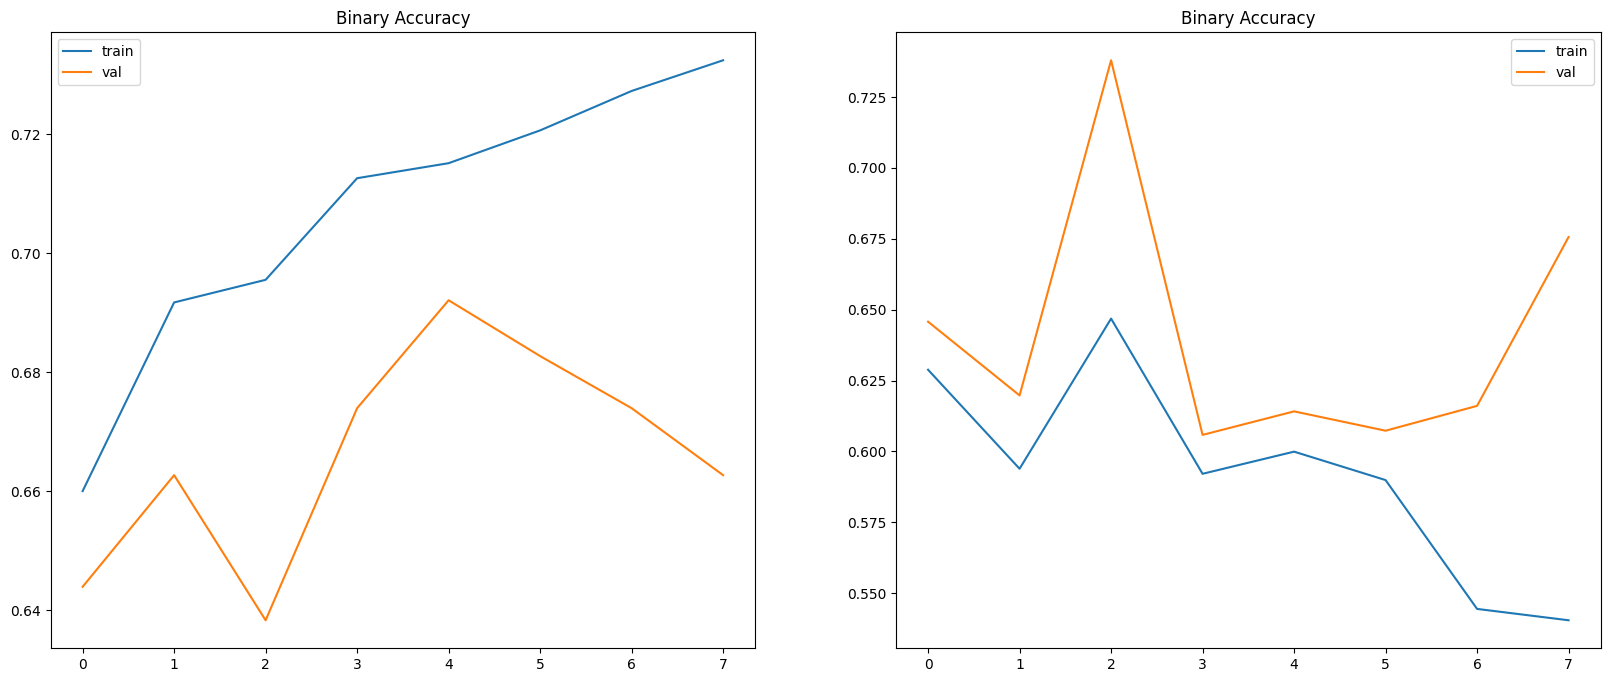

In [38]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()
plt.show()

In [40]:
evaluate_results = vgg16_model.evaluate(test_generator)
evaluate_results

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - binary_accuracy: 0.6734 - loss: 0.6272


[0.6234845519065857, 0.6760475039482117]

In [41]:
vgg16_model.save('vgg16_model.keras')

In [42]:
print(classification_report(test_generator.labels, (vgg16_model.predict(test_generator) >= 0.5).astype(int)))

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       830
           1       0.70      0.55      0.62       769

    accuracy                           0.67      1599
   macro avg       0.68      0.67      0.66      1599
weighted avg       0.67      0.67      0.66      1599



# VGG19

In [15]:
vgg19 = VGG19(include_top=False, input_shape=input_shape, weights='imagenet')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in vgg19.layers:
    layer.trainable = False

In [17]:
vgg19_model = tf.keras.Sequential([
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
vgg19_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
vgg19_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode="max",
    patience=5,
    restore_best_weights=True
)

In [21]:
history = vgg19_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/576 ━━━━━━━━━━━━━━━━━━━━ 7:04:55 44s/step - binary_accuracy: 0.3906 - loss: 0.9254

I0000 00:00:1713108814.686568      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - binary_accuracy: 0.6239 - loss: 0.6684 - val_binary_accuracy: 0.6383 - val_loss: 0.6870
Epoch 2/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 568s 975ms/step - binary_accuracy: 0.6898 - loss: 0.5963 - val_binary_accuracy: 0.6790 - val_loss: 0.6046
Epoch 3/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 564s 968ms/step - binary_accuracy: 0.6926 - loss: 0.5931 - val_binary_accuracy: 0.6508 - val_loss: 0.6615
Epoch 4/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 630s 982ms/step - binary_accuracy: 0.7030 - loss: 0.5804 - val_binary_accuracy: 0.6652 - val_loss: 0.6335
Epoch 5/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 578s 991ms/step - binary_accuracy: 0.7129 - loss: 0.5661 - val_binary_accuracy: 0.6496 - val_loss: 0.6455
Epoch 6/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 576s 988ms/step - binary_accuracy: 0.7087 - loss: 0.5923 - val_binary_accuracy: 0.6589 - val_loss: 0.6715
Epoch 7/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 573s 984ms/step - binary_accuracy: 0.7222 - loss: 0.5507 - val_binary_accuracy: 0.6715 - val_loss:

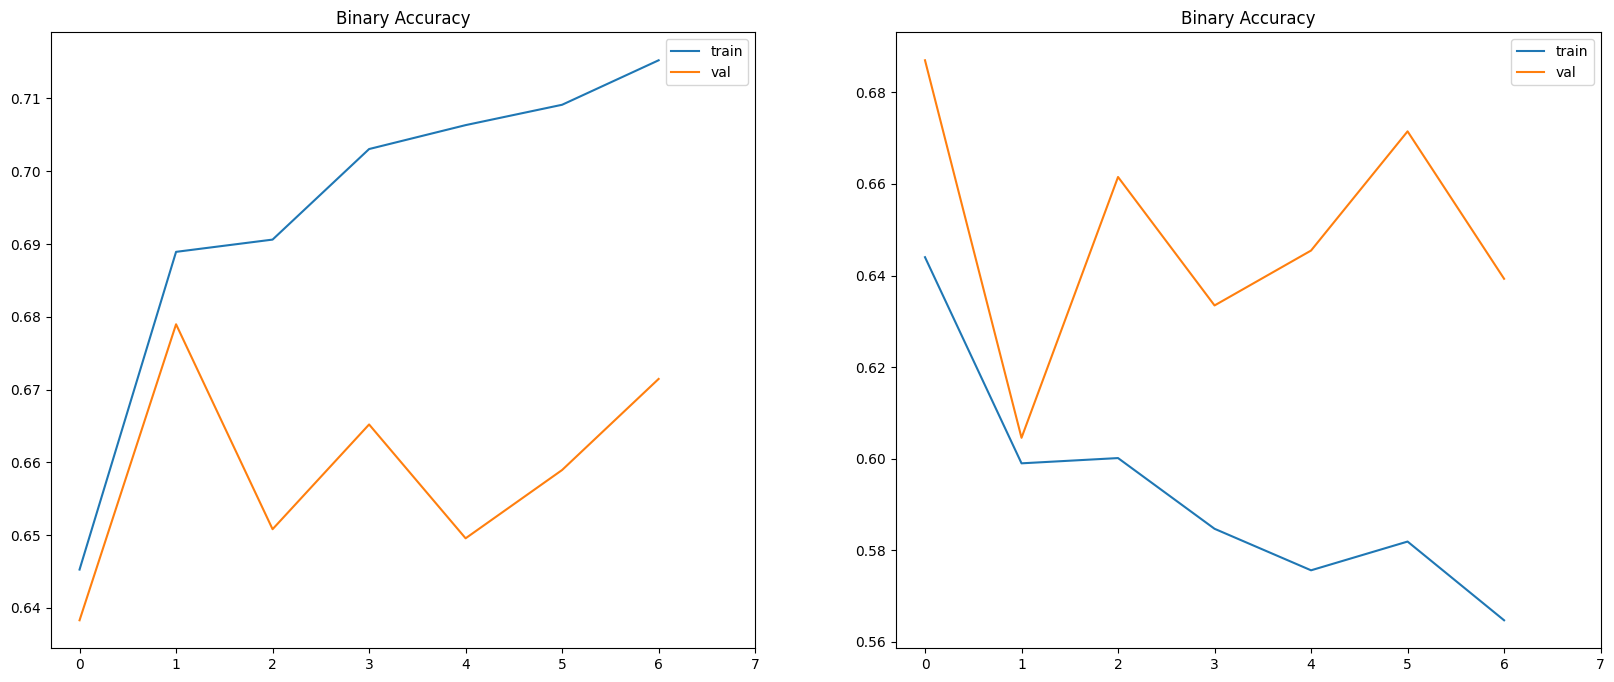

In [22]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()
plt.show()

In [23]:
evaluate_results = vgg19_model.evaluate(test_generator)
evaluate_results

25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - binary_accuracy: 0.6846 - loss: 0.5996


[0.6080806255340576, 0.6729205846786499]

In [25]:
vgg19_model.save('vgg19_model.keras')

In [26]:
print(classification_report(test_generator.labels, (vgg19_model.predict(test_generator) >= 0.5).astype(int)))

25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 894ms/step
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       830
           1       0.65      0.65      0.65       769

    accuracy                           0.66      1599
   macro avg       0.66      0.66      0.66      1599
weighted avg       0.66      0.66      0.66      1599

